# Grouped Conditional Expectation (GroupedCE) Explainer
Grouped Conditional Expectation (GroupedCE) Explainer is a local, model-agnostic explainer that generates Grouped Conditional Expectation (CE) plots for a given instance and a set of features. The set of features can be either a subset of the input covariates defined by the user or the top K features based on the importance provided by a global explainer (e.g., SHAP). The explainer produces 3D plots, containing the model output when pairs of features vary simultaneously. If a single feature is provided, the explainer produces standard 2D ICE plots, where only one feature is perturbed at a time.

<a id='notebook_workflow'></a>
## Notebook Workflow
- [Imports](#imports)
- [Load Dataset](#load_dataset)
- [Train Model](#train_model)
- [Compute Individual Conditional Expectation (ICE)](#initialize_and_compute_ice_explanation)
- [Plot ICE Explanation](#plot_ice_explanation)
- [Compute Grouped Conditional Expectation (GCE)](#initialize_and_compute_gce_explanation)
- [Plot GCE Explanation](#plot_Gce_explanation)

<a id='imports'></a>
### Imports

In [ ]:
!pip install plotly

In [1]:
import os
# to suppress unrelated tensorflow warnings while importing aix360.datasets
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import pandas as pd


<a id='load_dataset'></a>
### Load Dataset

The data is from [here](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html). Normalized version of this dataset can be found in [sklearn](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset). As described in the source links, this dataset consists of 10 baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

In [2]:
from aix360.datasets import DiabetesDataset

x_train, x_test, y_train, y_test, feature_names, target_names = DiabetesDataset().load_data(test_size=0.2, random_state=42, return_only_numerical=True)

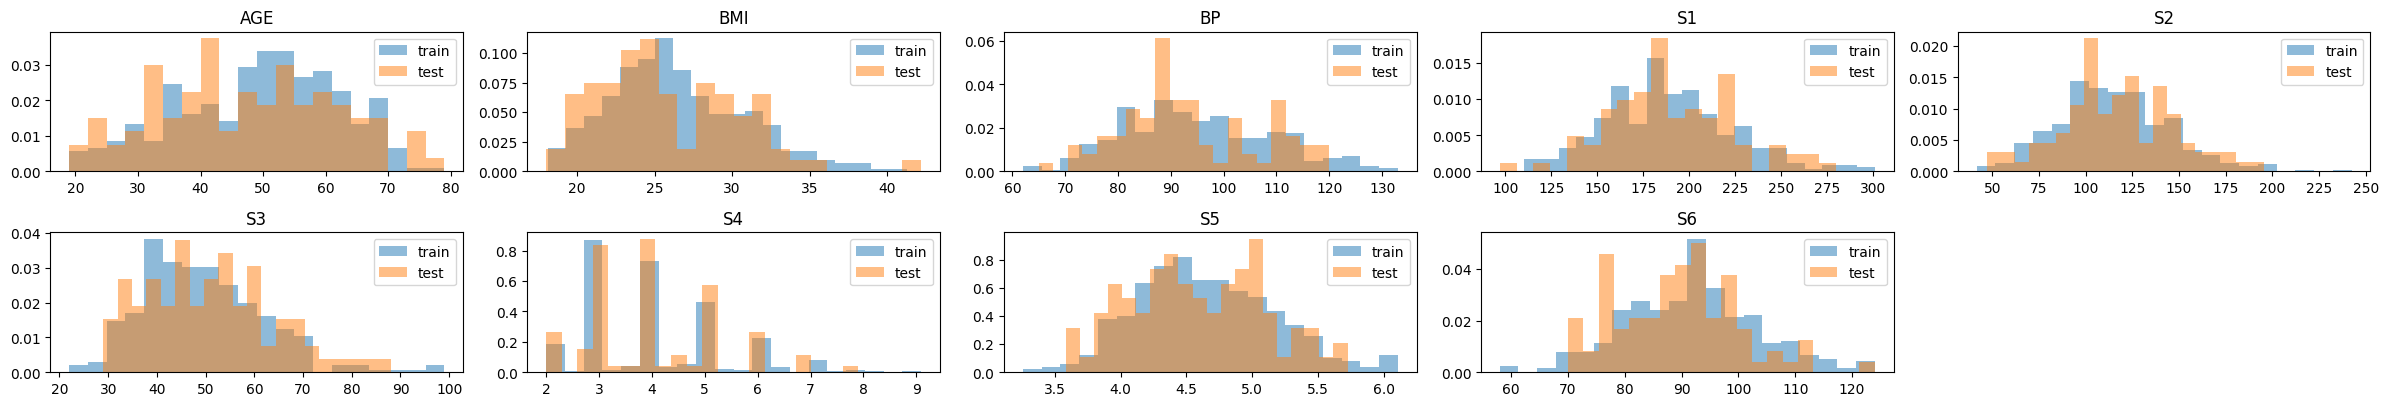

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize = (24,20))
for i in np.arange(x_train.shape[1]):
    plt.subplot(10,5,i+1)
    plt.title(feature_names[i])
    plt.hist(x_train[:,i], 20, label = 'train',density = True,alpha = 0.5)
    plt.hist(x_test[:,i], 20, label = 'test',density = True,alpha = 0.5)
    plt.legend()
plt.tight_layout()
plt.show()

<a id='train_model'></a>
## Train Model

Train RandomForestRegressor from scikit-learn.

In [4]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor().fit(x_train, y_train)


In [5]:
print('Score on train data :',clf.score(x_train, y_train))
print('Score on test data :',clf.score(x_test, y_test))

Score on train data : 0.9214355136165024
Score on test data : 0.4063775413197047


<a id='initialize_and_compute_ice_explanation'></a>
### Compute Individual Conditional Expectation (ICE)

Initialize GroupedCEExplainer to compute ICE scores for each feature. The explanation is a local explanation computed for single instance. Below cells demonstrate computation of ICE explanations on batch of instances along with plots.

In [6]:
from aix360.algorithms.gce.gce import GroupedCEExplainer

n_test_samples = 25 # number of instances to explain
n_samples = 100 # number of samples to generate for selected feature

ice_explanations = {}
for i, feature_col in enumerate(feature_names):
    ice_explainer = GroupedCEExplainer(model=clf.predict,
                                       data=x_train, 
                                       feature_names=feature_names,
                                         n_samples=n_samples,
                                         features_selected=[feature_col],
                                        random_seed=22
                                  )
    ice_explanations[feature_col] = []
    for i in range(n_test_samples):
        ice_explanations[feature_col].append(ice_explainer.explain_instance(instance=x_test[[i], :]))

<a id='plot_ice_explanation'></a>
### Plot ICE Explanation

`plots.plot_ice_explanation` has helper code to plot the ICE explanation. For a different dataset or variation of plot, you can update the code `plots.py`.

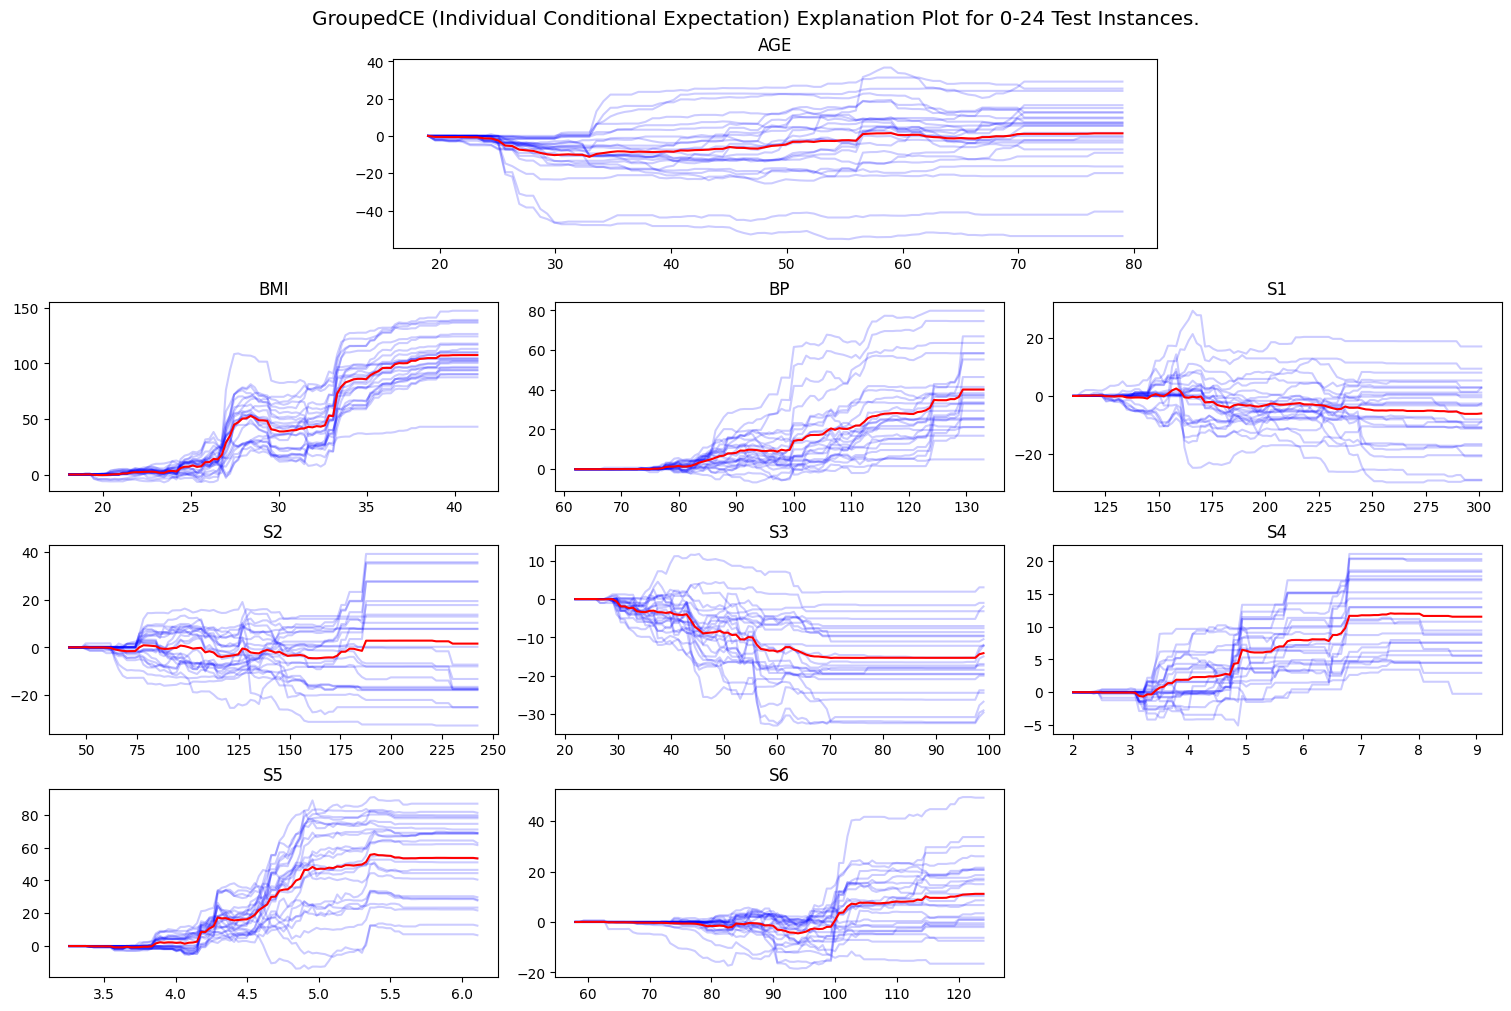

In [7]:
from plots import plot_ice_explanation
plot_ice_explanation(ice_explanations, title="GroupedCE (Individual Conditional Expectation) Explanation Plot for {}-{} Test Instances.".format(0, n_test_samples-1))

From above ICE plots, model prediction increases linearly as BMI and BP features are increased.

<a id='initialize_and_compute_gce_explanation'></a>
### Compute Grouped Conditional Expectation (GCE)
Initialize GroupedCEExplainer to compute GCE scores for each feature. The explanation is a local explanation computed for single instance. Each cell in the resulting grid explains how a combination of feature values (example BPM and BP) impact model prediction.

In [8]:
from aix360.algorithms.gce.gce import GroupedCEExplainer

n_samples = 100
top_k_features = 4

# initialization
groupedce_explainer = GroupedCEExplainer(model=clf.predict,
                                         data=x_train, 
                                         feature_names=feature_names,
                                         n_samples=n_samples,
                                         top_k_features=top_k_features,
                                        random_seed=22)


  0%|          | 0/10 [00:00<?, ?it/s]

Considering Top 4 features according to SHAP: ['BMI', 'BP', 'S5', 'AGE']


In [9]:
i = 0
x_instance = x_test[[i], :]

In [10]:
# compute explanation
groupedce_explanation = groupedce_explainer.explain_instance(instance=x_instance)

<a id='plot_gce_explanation'></a>
### Plot GCE Explanation

`plots.plot_gce_explanation` has helper code to plot the GroupedCE (GCE) explanation. For a different dataset or variation of plot, you can update the code `plots.py`.

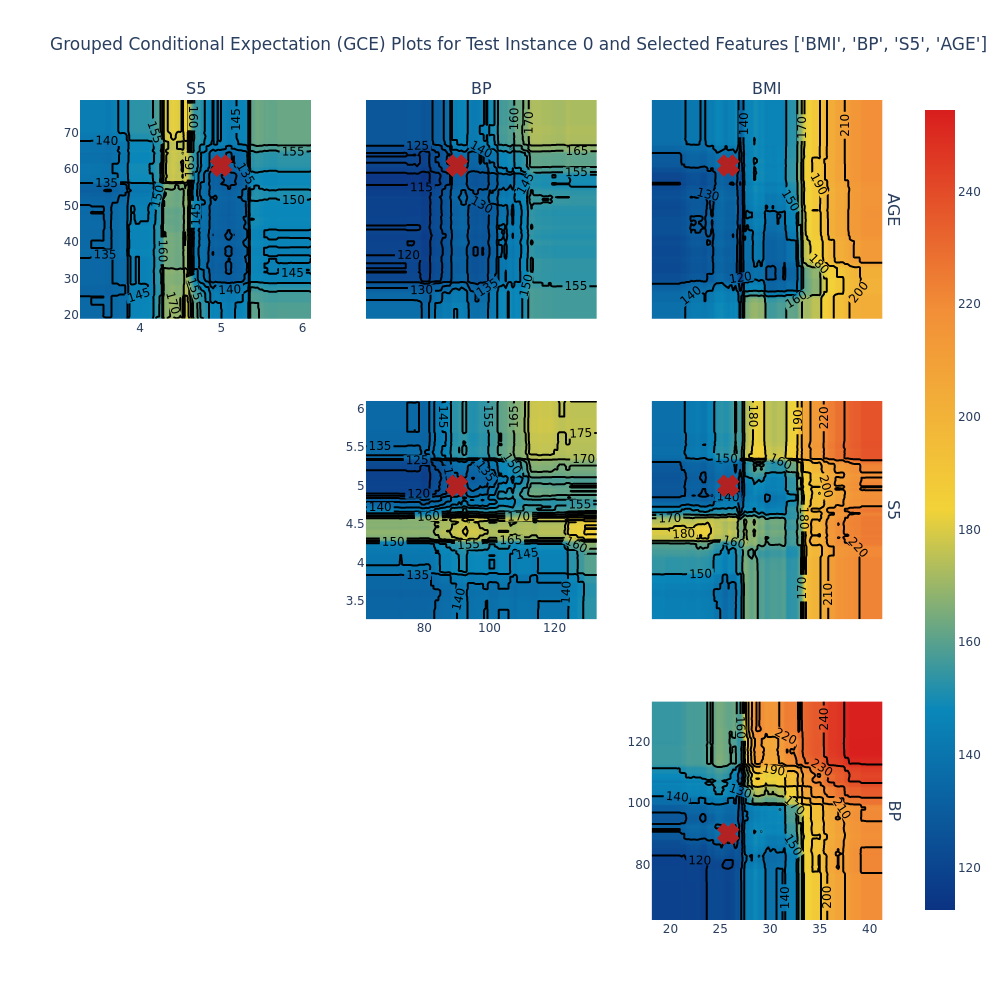

In [11]:
from IPython.display import Image
from plots import plot_gce_explanation

title="Grouped Conditional Expectation (GCE) Plots for Test Instance {} and Selected Features {}".format(i, groupedce_explanation['selected_features'])

fig = plot_gce_explanation(groupedce_explanation, title=title)
dataset_plot_bytes = fig.to_image(format="png", width=1000, height=1000)
Image(dataset_plot_bytes)

Above GCE plot show that BMI has more impact on model prediction compared to BP, S3 and S5.